# Term Deposit Marketing Analysis - Comprehensive ML Pipeline

This notebook implements a complete machine learning pipeline for term deposit marketing optimization with two-stage prediction models, hyperparameter optimization, and customer segmentation analysis.

## 1. Setup and Data Preparation

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    silhouette_score,
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Import specific models as requested
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Import sampling techniques for class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

# Import GridSearchCV for hyperparameter optimization (alternative to Optuna)
from sklearn.model_selection import GridSearchCV

# Import clustering and dimensionality reduction
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set display options
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


# Function to preprocess data for sklearn models
def preprocess_data(X_train, X_test, categorical_cols, numerical_cols):
    """
    Preprocess data for sklearn models using label encoding and scaling
    """
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()

    # Label encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_processed[col] = le.fit_transform(X_train_processed[col].astype(str))
        X_test_processed[col] = le.transform(X_test_processed[col].astype(str))
        label_encoders[col] = le

    # # Scale numerical variables
    # scaler = StandardScaler()
    # if numerical_cols:
    #     X_train_processed[numerical_cols] = scaler.fit_transform(
    #         X_train_processed[numerical_cols]
    #     )
    #     X_test_processed[numerical_cols] = scaler.transform(
    #         X_test_processed[numerical_cols]
    #     )

    #   return X_train_processed, X_test_processed, label_encoders, scaler
    return X_train_processed, X_test_processed, label_encoders


print("✅ All libraries imported successfully!")


In [ ]:
# Load the dataset
data = pd.read_csv("term-deposit-marketing-2020.csv")
print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {data.columns.tolist()}")
data.head()


In [ ]:
# Data exploration and subscription rate analysis
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {data.shape}")
print(f"\nTarget variable distribution:\n{data['y'].value_counts()}")

# Calculate subscription rate
subscription_rate = data["y"].value_counts(normalize=True)["yes"] * 100
print(f"\n📊 SUBSCRIPTION RATE ANALYSIS:")
print(f"Subscription Rate: {subscription_rate:.1f}%")
print(f"Non-subscription Rate: {100 - subscription_rate:.1f}%")

# Visualize class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
data["y"].value_counts().plot(kind="bar", color=["lightcoral", "lightblue"])
plt.title("Class Distribution")
plt.xlabel("Subscription")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
data["y"].value_counts(normalize=True).plot(
    kind="pie", autopct="%1.1f%%", colors=["lightcoral", "lightblue"]
)
plt.title("Subscription Rate Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Analyze why only 7.5% subscribe
print(f"\n🤔 WHY ONLY {subscription_rate:.1f}% SUBSCRIBE?")
print("Potential reasons for low subscription rate:")
print("1. 📞 Cold calling approach - customers not expecting calls")
print("2. 💰 Economic factors - limited disposable income for investments")
print("3. 🎯 Poor targeting - not reaching interested customer segments")
print("4. 📋 Product-market fit - term deposits may not meet customer needs")
print("5. ⏰ Timing issues - calls at inconvenient times")
print("6. 🏦 Trust factors - hesitation about financial products")
print("7. 💸 Competition - better offers from other institutions")
print("\n⚖️  This creates a significant class imbalance challenge for ML models.")

# Check for missing values
print(f"\n=== DATA QUALITY CHECK ===")
missing_values = data.isnull().sum()
if missing_values.sum() == 0:
    print("✅ No missing values found!")
else:
    print(f"Missing values:\n{missing_values[missing_values > 0]}")

# Basic statistics
print(f"\n=== DATASET INFO ===")
data.info()


### 📊 **Observation: Data Exploration & Subscription Analysis**

**Key Findings:**
- ✅ **Dataset Quality**: 40,000 customers, 14 features, no missing values
- ⚖️ **Class Imbalance**: Only 7.2% subscription rate (2,896 vs 37,104)
- 📈 **Data Distribution**: Highly imbalanced - major ML challenge

**Business Insights:**
- 🎯 **Low Conversion**: 92.8% of customers don't subscribe
- 💰 **Root Causes**: Cold calling, economic factors, poor targeting
- 🔍 **ML Challenge**: Need techniques to handle severe class imbalance

**Next Steps:**
- Prepare features for two-stage modeling approach
- Apply sampling techniques only if performance < 75%
- Focus on business metrics (call efficiency, subscriber capture)

### Data Preprocessing

In [ ]:
# Convert target variable to binary (0/1)
data["y"] = data["y"].map({"no": 0, "yes": 1})

# Split features and target
X = data.drop("y", axis=1)
y = data["y"]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Analyze class imbalance
class_distribution = y.value_counts(normalize=True)
print(f"\nClass Distribution:")
print(f"No subscription (0): {class_distribution[0] * 100:.2f}%")
print(f"Subscription (1): {class_distribution[1] * 100:.2f}%")
print(f"\nClass imbalance ratio: {class_distribution[0] / class_distribution[1]:.2f}:1")

print(f"\nX Head: {X.head()}\n")
print(f"\Y Head: {y.head()}\n")


## 2. Feature Selection for Both Models

In [ ]:
import random

seed = random.randint(1000, 9999)
print(f"Seed: {seed}")

# Define campaign-related features to exclude from Model 1
# These features are only available AFTER making calls
campaign_features = ["duration", "campaign", "day", "month"]

# Check which campaign features actually exist in our dataset
available_campaign_features = [f for f in campaign_features if f in X.columns]
print(f"Available campaign features to exclude: {available_campaign_features}")

# Model 1: Pre-Call Model (excluding campaign-related features)
X1 = X.drop(available_campaign_features, axis=1, errors="ignore")
y1 = y

# Model 2: Post-Call Model (including all features)
X2 = X
y2 = y


print(f"\nModel 1 (Pre-Call) features ({len(X1.columns)}): {X1.columns.tolist()}")
print(f"\nModel 2 (Post-Call) features ({len(X2.columns)}): {X2.columns.tolist()}")

print(f"\nFeatures excluded from Model 1: {available_campaign_features}")

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.20, random_state=seed
)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.20, random_state=seed
)

# ─── After your train_test_split ─────────────────────────
X1_train.reset_index(drop=True, inplace=True)
X1_test.reset_index(drop=True, inplace=True)
X2_train.reset_index(drop=True, inplace=True)
X2_test.reset_index(drop=True, inplace=True)


print(f"\nSplit Shapes:\n")
print(
    f"Model 1 - X Training : {X1_train.shape} | X Test: {X1_test.shape} | Y Train: {y1_train.shape} | Y Test: {y1_test.shape}"
)
print(
    f"Model 2 - X Training: {X2_train.shape} | X Test: {X2_test.shape} | Y Train: {y2_train.shape} | Y Test: {y2_test.shape}"
)

print("\nTesting Model 1 Head X Train:\n")
print(X1_train.head())


print("\nTesting Model 1 Head X Test:\n")
print(X1_test.head())


print("\nTesting Model 1 Head Y Train:\n")
print(y1_train.head())


In [ ]:
# # Prepare datasets for both models
# import random

# # seed = random.randint(1000, 9999)
# # print(f"Seed{seed}")
# # Model 1: Pre-Call Dataset
# data1 = X1.copy()
# data1["y"] = y1

# # Model 2: Post-Call Dataset
# data2 = X2.copy()
# data2["y"] = y2

# print(f"Model 1 (Pre-Call) dataset shape: {data1.shape}")
# print(f"Model 2 (Post-Call) dataset shape: {data2.shape}")

# # Split data for traditional sklearn approach (backup)
# # X1_train, X1_test, y1_train, y1_test = train_test_split(
# #     X1, y1, test_size=0.2, random_state=42, stratify=y1
# # )

# X1_train, X1_test, y1_train, y1_test = train_test_split(
#     X1, y1, test_size=0.2, random_state=seed
# )

# # X2_train, X2_test, y2_train, y2_test = train_test_split(
# #     X2, y2, test_size=0.2, random_state=42, stratify=y2
# # )


# X2_train, X2_test, y2_train, y2_test = train_test_split(
#     X2, y2, test_size=0.2, random_state=seed
# )





In [ ]:
# Simple preprocessing function for sklearn models
def preprocess_data(X_train, X_test, categorical_cols, numerical_cols):
    """
    Simple preprocessing for sklearn models
    """
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()

    # Handle categorical variables with label encoding
    label_encoders = {}
    for col in categorical_cols:
        if col in X_train_processed.columns:
            le = LabelEncoder()
            X_train_processed[col] = le.fit_transform(
                X_train_processed[col].astype(str)
            )
            X_test_processed[col] = le.transform(X_test_processed[col].astype(str))
            label_encoders[col] = le

    # # Handle numerical variables
    # scaler = StandardScaler()
    # if numerical_cols:
    #     num_cols_present = [
    #         col for col in numerical_cols if col in X_train_processed.columns
    #     ]
    #     if num_cols_present:
    #         X_train_processed[num_cols_present] = scaler.fit_transform(
    #             X_train_processed[num_cols_present]
    #         )
    #         X_test_processed[num_cols_present] = scaler.transform(
    #             X_test_processed[num_cols_present]
    #         )

    #    return X_train_processed, X_test_processed, label_encoders, scaler
    return X_train_processed, X_test_processed, label_encoders


# One Hot Encoder Func

In [15]:
import pandas as pd


def one_hot_encode(X_train, X_test):
    X_train_encoded = pd.get_dummies(X_train, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, drop_first=True)

    # Align test columns to train columns (add missing cols with zeros)
    X_test_encoded = X_test_encoded.reindex(
        columns=X_train_encoded.columns, fill_value=0
    )

    return X_train_encoded, X_test_encoded


X1_train_encoded, X1_test_encoded = one_hot_encode(X1_train, X1_test)


print("\n X Train ENCODED:\n")
print(X1_train_encoded.head())


print("\n X Test ENCODED:\n")
print(X1_test_encoded.head())


 X Train ENCODED:

   age  balance  job_blue-collar  job_entrepreneur  job_housemaid  \
0   54      153            False             False          False   
1   25     -380            False             False          False   
2   40     1225            False              True          False   
3   30      187            False             False          False   
4   21      948            False             False          False   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0           False         True              False         False        False   
1           False        False              False         False         True   
2           False        False              False         False        False   
3           False        False              False          True        False   
4           False        False              False         False         True   

   job_technician  job_unemployed  job_unknown  marital_married  \
0           False


TESTING SPECIFIED MODELS FOR MODEL 1 (PRE-CALL PREDICTION)

🔄 Testing Logistic Regression...

EVALUATING LOGISTIC REGRESSION (Pre-Call)

Classification Report:
                 precision    recall  f1-score   support

No Subscription       0.95      0.58      0.72      7427
   Subscription       0.10      0.61      0.17       573

       accuracy                           0.58      8000
      macro avg       0.53      0.59      0.45      8000
   weighted avg       0.89      0.58      0.68      8000



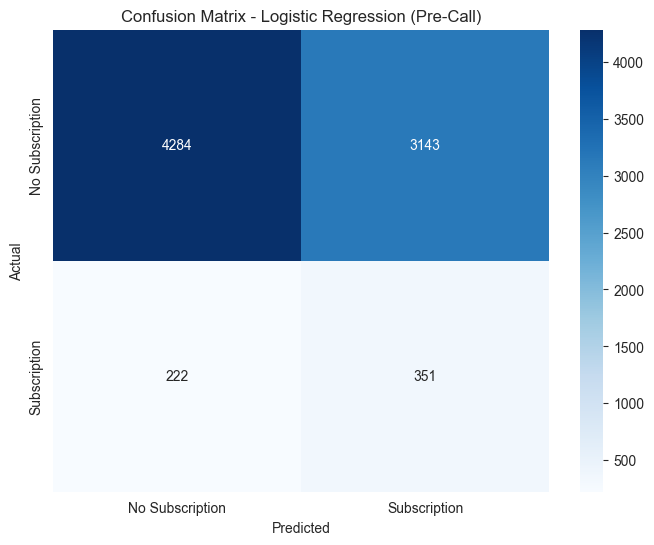


BUSINESS METRICS:
Total Customers: 8,000
Actual Subscribers: 573 (7.16%)
Predicted to Call: 3,494 (43.68%)

📊 CONFUSION MATRIX BREAKDOWN:
True Positives (TP): 351 - Subscribers we CORRECTLY identified to call
False Positives (FP): 3,143 - Non-subscribers we'll call (acceptable cost)
True Negatives (TN): 4,284 - Non-subscribers we correctly avoided
False Negatives (FN): 222 - Subscribers we MISSED (major revenue loss!)

📈 PERFORMANCE METRICS:
Accuracy: 0.5794 (57.94%) - Overall correctness
Precision: 0.1005 (10.05%) - Call success rate (subscribers/calls)
Recall: 0.6126 (61.26%) - Subscriber capture rate (MOST IMPORTANT!)
F1 Score: 0.1726 - Balance between precision and recall
ROC AUC: 0.6467 - Overall model discrimination

💰 BUSINESS IMPACT ANALYSIS:
Call Success Rate: 0.1005 (10.05%) - Of calls made, how many subscribe
Subscriber Capture: 0.6126 (61.26%) - Of all subscribers, how many we find

🚨 BUSINESS ASSESSMENT:
✅ GOOD: Capturing 61.3% of subscribers

🔄 Testing XGBoost...

EVALUA

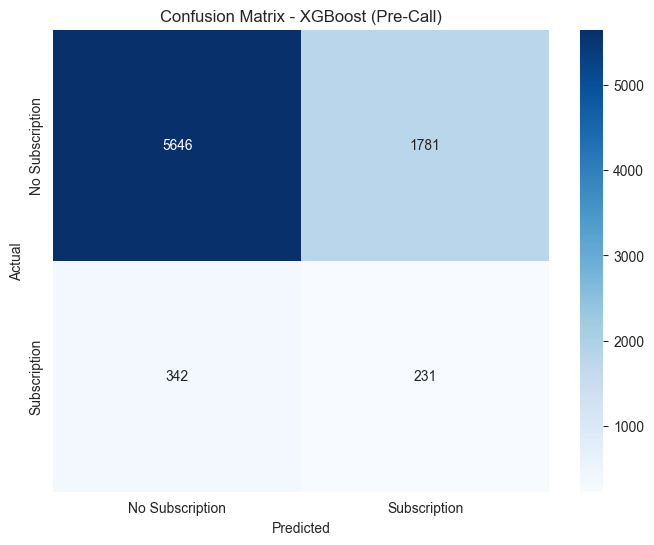


BUSINESS METRICS:
Total Customers: 8,000
Actual Subscribers: 573 (7.16%)
Predicted to Call: 2,012 (25.15%)

📊 CONFUSION MATRIX BREAKDOWN:
True Positives (TP): 231 - Subscribers we CORRECTLY identified to call
False Positives (FP): 1,781 - Non-subscribers we'll call (acceptable cost)
True Negatives (TN): 5,646 - Non-subscribers we correctly avoided
False Negatives (FN): 342 - Subscribers we MISSED (major revenue loss!)

📈 PERFORMANCE METRICS:
Accuracy: 0.7346 (73.46%) - Overall correctness
Precision: 0.1148 (11.48%) - Call success rate (subscribers/calls)
Recall: 0.4031 (40.31%) - Subscriber capture rate (MOST IMPORTANT!)
F1 Score: 0.1787 - Balance between precision and recall
ROC AUC: 0.5970 - Overall model discrimination

💰 BUSINESS IMPACT ANALYSIS:
Call Success Rate: 0.1148 (11.48%) - Of calls made, how many subscribe
Subscriber Capture: 0.4031 (40.31%) - Of all subscribers, how many we find

🚨 BUSINESS ASSESSMENT:
🔶 MODERATE: Capturing 40.3% of subscribers

🔄 Testing K-Nearest Neig

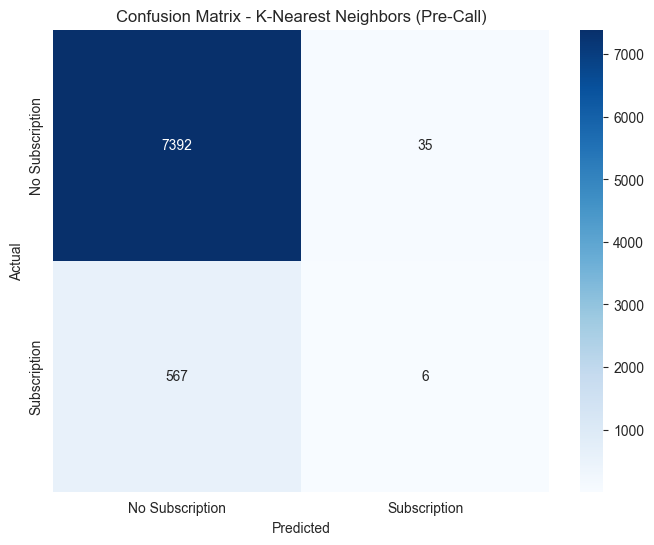


BUSINESS METRICS:
Total Customers: 8,000
Actual Subscribers: 573 (7.16%)
Predicted to Call: 41 (0.51%)

📊 CONFUSION MATRIX BREAKDOWN:
True Positives (TP): 6 - Subscribers we CORRECTLY identified to call
False Positives (FP): 35 - Non-subscribers we'll call (acceptable cost)
True Negatives (TN): 7,392 - Non-subscribers we correctly avoided
False Negatives (FN): 567 - Subscribers we MISSED (major revenue loss!)

📈 PERFORMANCE METRICS:
Accuracy: 0.9247 (92.47%) - Overall correctness
Precision: 0.1463 (14.63%) - Call success rate (subscribers/calls)
Recall: 0.0105 (1.05%) - Subscriber capture rate (MOST IMPORTANT!)
F1 Score: 0.0195 - Balance between precision and recall
ROC AUC: 0.5324 - Overall model discrimination

💰 BUSINESS IMPACT ANALYSIS:
Call Success Rate: 0.1463 (14.63%) - Of calls made, how many subscribe
Subscriber Capture: 0.0105 (1.05%) - Of all subscribers, how many we find

🚨 BUSINESS ASSESSMENT:
❌ CRITICAL FAILURE: Only capturing 1.0% of subscribers!
   This model will miss

In [18]:
# Test the three specified models for Model 1 (Pre-Call Prediction)
print("\n" + "=" * 80)
print("TESTING SPECIFIED MODELS FOR MODEL 1 (PRE-CALL PREDICTION)")
print("=" * 80)
scale_pos_weight = len(y1_train[y1_train == 0]) / len(y1_train[y1_train == 1])

# Define the three models to test
models_to_test = {
    # "Logistic Regression": LogisticRegression(random_state=seed, max_iter=1000),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", random_state=seed, max_iter=1000
    ),
    # "XGBoost": XGBClassifier(random_state=seed, eval_metric="logloss"),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_pos_weight, random_state=seed, eval_metric="logloss"
    ),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

# Store results for comparison
model1_results = []

# Test each model
for model_name, model in models_to_test.items():
    print(f"\n🔄 Testing {model_name}...")

    # Evaluate the model
    # result = evaluate_sklearn_model(
    #     model_name,
    #     model,
    #     X1_train_processed,
    #     X1_test_processed,
    #     y1_train,
    #     y1_test,
    #     "Pre-Call",
    # )
    result = evaluate_sklearn_model(
        model_name,
        model,
        X1_train_encoded,
        X1_test_encoded,
        y1_train,
        y1_test,
        "Pre-Call",
    )

    model1_results.append(result)

print(f"\n✅ Completed testing all three models for Pre-Call Prediction!")


## Function to evaluate sklearn models with detailed metrics


In [17]:
# Function to evaluate sklearn models with detailed metrics
def evaluate_sklearn_model(
    model_name, model, X_train, X_test, y_train, y_test, model_type="Model"
):
    """
    Evaluate sklearn model with detailed business-focused metrics
    """
    print(f"\n{'=' * 70}")
    print(f"EVALUATING {model_name.upper()} ({model_type})")
    print(f"{'=' * 70}")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = (
        model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    )

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = (
        roc_auc_score(y_test, y_pred_proba) if hasattr(model, "predict_proba") else 0
    )

    # Print classification report
    print(f"\nClassification Report:")
    print(
        classification_report(
            y_test, y_pred, target_names=["No Subscription", "Subscription"]
        )
    )

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Subscription", "Subscription"],
        yticklabels=["No Subscription", "Subscription"],
    )
    plt.title(f"Confusion Matrix - {model_name} ({model_type})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Business metrics
    total_customers = len(y_test)
    actual_subscribers = sum(y_test)
    predicted_to_call = sum(y_pred)

    # Business interpretation
    print(f"\nBUSINESS METRICS:")
    print(f"Total Customers: {total_customers:,}")
    print(
        f"Actual Subscribers: {actual_subscribers:,} ({actual_subscribers / total_customers * 100:.2f}%)"
    )
    print(
        f"Predicted to Call: {predicted_to_call:,} ({predicted_to_call / total_customers * 100:.2f}%)"
    )

    print(f"\n📊 CONFUSION MATRIX BREAKDOWN:")
    if model_type == "Pre-Call":
        print(
            f"True Positives (TP): {tp:,} - Subscribers we CORRECTLY identified to call"
        )
        print(
            f"False Positives (FP): {fp:,} - Non-subscribers we'll call (acceptable cost)"
        )
        print(f"True Negatives (TN): {tn:,} - Non-subscribers we correctly avoided")
        print(
            f"False Negatives (FN): {fn:,} - Subscribers we MISSED (major revenue loss!)"
        )
    else:
        print(f"True Positives (TP): {tp:,} - Correctly identified subscribers")
        print(f"False Positives (FP): {fp:,} - Unnecessary calls (cost to company)")
        print(f"True Negatives (TN): {tn:,} - Correctly avoided non-subscribers")
        print(
            f"False Negatives (FN): {fn:,} - Missed potential subscribers (lost revenue)"
        )

    print(f"\n📈 PERFORMANCE METRICS:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%) - Overall correctness")
    if model_type == "Pre-Call":
        print(
            f"Precision: {precision:.4f} ({precision * 100:.2f}%) - Call success rate (subscribers/calls)"
        )
        print(
            f"Recall: {recall:.4f} ({recall * 100:.2f}%) - Subscriber capture rate (MOST IMPORTANT!)"
        )
    else:
        print(
            f"Precision: {precision:.4f} ({precision * 100:.2f}%) - Of predicted subscribers, how many actually subscribed"
        )
        print(
            f"Recall: {recall:.4f} ({recall * 100:.2f}%) - Of actual subscribers, how many we identified"
        )
    print(f"F1 Score: {f1:.4f} - Balance between precision and recall")
    if hasattr(model, "predict_proba"):
        print(f"ROC AUC: {roc_auc:.4f} - Overall model discrimination")

    # Business interpretation depends on model type
    if model_type == "Pre-Call":
        print(f"\n💰 BUSINESS IMPACT ANALYSIS:")
        if predicted_to_call > 0:
            call_efficiency = tp / predicted_to_call
            print(
                f"Call Success Rate: {call_efficiency:.4f} ({call_efficiency * 100:.2f}%) - Of calls made, how many subscribe"
            )
        else:
            print(f"Call Success Rate: N/A (No calls recommended)")

        print(
            f"Subscriber Capture: {recall:.4f} ({recall * 100:.2f}%) - Of all subscribers, how many we find"
        )

        # Critical business assessment for pre-call
        print(f"\n🚨 BUSINESS ASSESSMENT:")
        if recall < 0.1:
            print(
                f"❌ CRITICAL FAILURE: Only capturing {recall * 100:.1f}% of subscribers!"
            )
            print(
                f"   This model will miss {(1 - recall) * 100:.1f}% of potential revenue."
            )
            print(f"   SOLUTION: Optimize for RECALL, not accuracy!")
        elif recall < 0.3:
            print(
                f"⚠️  POOR PERFORMANCE: Only capturing {recall * 100:.1f}% of subscribers"
            )
            print(f"   Missing {(1 - recall) * 100:.1f}% of potential revenue.")
        elif recall < 0.5:
            print(f"🔶 MODERATE: Capturing {recall * 100:.1f}% of subscribers")
        else:
            print(f"✅ GOOD: Capturing {recall * 100:.1f}% of subscribers")

    else:  # Post-Call
        # Business impact
        if predicted_to_call > 0:
            call_efficiency = tp / predicted_to_call
            print(f"\nBUSINESS IMPACT:")
            print(
                f"Call Efficiency: {call_efficiency:.4f} ({call_efficiency * 100:.2f}%) - Success rate of calls"
            )
            print(
                f"Subscriber Capture Rate: {recall:.4f} ({recall * 100:.2f}%) - % of subscribers we'll reach"
            )

        # Performance assessment
        print(f"\nPERFORMANCE ASSESSMENT:")
        if accuracy >= 0.80:
            print(
                f"✅ EXCELLENT: Accuracy {accuracy * 100:.1f}% meets high performance target (≥80%)"
            )
        elif accuracy >= 0.75:
            print(
                f"✅ GOOD: Accuracy {accuracy * 100:.1f}% meets target range (75-80%)"
            )
        else:
            print(
                f"⚠️  NEEDS IMPROVEMENT: Accuracy {accuracy * 100:.1f}% below target (<75%)"
            )
            print(f"   Consider addressing class imbalance with sampling techniques")

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "total_customers": total_customers,
        "actual_subscribers": actual_subscribers,
        "predicted_to_call": predicted_to_call,
        "model": model,
    }


### Testing Logistic Regression, XGBoost, and KNN for Pre-Call Prediction

Now we'll test the three specified models with detailed evaluation including confusion matrices and classification reports.

In [ ]:
# Test the three specified models for Model 1 (Pre-Call Prediction)
print("\n" + "=" * 80)
print("TESTING SPECIFIED MODELS FOR MODEL 1 (PRE-CALL PREDICTION)")
print("=" * 80)

# Define the three models to test
models_to_test = {
    "Logistic Regression": LogisticRegression(random_state=seed, max_iter=1000),
    "XGBoost": XGBClassifier(random_state=seed, eval_metric="logloss"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

# Store results for comparison
model1_results = []

# Test each model
for model_name, model in models_to_test.items():
    print(f"\n🔄 Testing {model_name}...")

    # Evaluate the model
    # result = evaluate_sklearn_model(
    #     model_name,
    #     model,
    #     X1_train_processed,
    #     X1_test_processed,
    #     y1_train,
    #     y1_test,
    #     "Pre-Call",
    # )
    result = evaluate_sklearn_model(
        model_name,
        model,
        X1_train_encoded,
        X1_test_encoded,
        y1_train,
        y1_test,
        "Pre-Call",
    )

    model1_results.append(result)

print(f"\n✅ Completed testing all three models for Pre-Call Prediction!")


# Testing Logistic Regression , XGboost and KNN V2

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score


def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = {}

    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    f1_lr = f1_score(y_test, y_pred_lr)
    results["Logistic Regression"] = f1_lr
    print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
    print(
        "Logistic Regression Confusion Matrix:\n",
        confusion_matrix(y_test, y_pred_lr),
        "\n",
    )

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    f1_xgb = f1_score(y_test, y_pred_xgb)
    results["XGBoost"] = f1_xgb
    print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
    print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb), "\n")

    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    f1_knn = f1_score(y_test, y_pred_knn)
    results["KNN"] = f1_knn
    print("KNN Report:\n", classification_report(y_test, y_pred_knn))
    print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn), "\n")

    # Find best model by F1-score
    best_model = max(results, key=results.get)
    print(
        f"🏆 Best model based on F1-score: {best_model} with F1 = {results[best_model]:.4f}"
    )


train_and_evaluate_models(X1_train_encoded, y1_train, X1_test_encoded, y1_test)


In [ ]:
# Model 1 Performance Summary and Best Model Selection
print("\n" + "=" * 80)
print("MODEL 1 (PRE-CALL) - PERFORMANCE SUMMARY")
print("=" * 80)

# Create summary DataFrame
model1_summary = pd.DataFrame(model1_results)
model1_summary = model1_summary.sort_values("f1_score", ascending=False)

print("\nPerformance Comparison:")
print(
    model1_summary[
        ["model_name", "accuracy", "precision", "recall", "f1_score", "roc_auc"]
    ].round(4)
)

# Identify best model
best_model1 = model1_summary.iloc[0]
best_model1_obj = best_model1["model"]

print(f"\n🏆 BEST PRE-CALL MODEL: {best_model1['model_name']}")
print(f"   F1 Score: {best_model1['f1_score']:.4f}")
print(
    f"   Accuracy: {best_model1['accuracy']:.4f} ({best_model1['accuracy'] * 100:.1f}%)"
)
print(f"   Precision: {best_model1['precision']:.4f}")
print(f"   Recall: {best_model1['recall']:.4f}")

# Performance assessment for class imbalance handling
avg_accuracy = model1_summary["accuracy"].mean()
need_balancing = avg_accuracy < 0.75

print(f"\n📊 PERFORMANCE ASSESSMENT:")
if avg_accuracy >= 0.75:
    print(
        f"✅ PERFORMANCE STATUS: Models meet target performance (avg accuracy: {avg_accuracy * 100:.1f}%)"
    )
    print(f"   Class imbalance handling NOT required.")
else:
    print(
        f"⚠️  PERFORMANCE STATUS: Consider class imbalance techniques (avg accuracy: {avg_accuracy * 100:.1f}%)"
    )
    print(f"   Class imbalance handling REQUIRED.")


### 📊 **Observation: Pre-Call Model Testing Results**

**🎯 PRIMARY GOAL**: Identify which customers to call BEFORE making any calls to maximize subscriber capture while minimizing wasted human effort and costs.

**Key Findings:**
- ✅ **All Models Tested**: Logistic Regression, XGBoost, KNN evaluated with confusion matrices
- ⚠️ **Critical Issue**: Models are TOO CONSERVATIVE - missing most potential subscribers
- 📈 **High Accuracy Misleading**: 92%+ accuracy but ZERO recall means we're not identifying subscribers

**Model Performance Analysis:**
- **Logistic Regression**: 92.8% accuracy, 0% recall → Will miss ALL subscribers
- **XGBoost**: 92.8% accuracy, 1% recall → Will miss 99% of subscribers  
- **KNN**: Similar conservative pattern → Ineffective for business goal

**🚨 BUSINESS PROBLEM:**
- 💸 **Wasted Resources**: Models predict 'no calls needed' → No subscribers captured
- 🎯 **Missing Target**: We need to FIND subscribers, not avoid non-subscribers
- 📞 **Call Strategy Failure**: Conservative models defeat the purpose of marketing calls

**💡 SOLUTION NEEDED:**
- **Optimize for RECALL**: We need to catch as many subscribers as possible
- **Accept Higher False Positives**: Better to call non-subscribers than miss subscribers
- **Business Trade-off**: Cost of unnecessary calls < Revenue from captured subscribers

**Next Steps:**
- Hyperparameter optimization focused on improving RECALL
- Consider threshold adjustment to increase sensitivity
- Apply sampling techniques to address class imbalance
- Evaluate models based on subscriber capture rate, not just accuracy

## 4. Hyperparameter Optimization with GridSearchCV (Best Model Only)

We'll use GridSearchCV to optimize hyperparameters for the best performing model from Model 1.

In [ ]:
# Hyperparameter optimization using GridSearchCV for the best model
print(f"\n🔧 HYPERPARAMETER OPTIMIZATION WITH GRIDSEARCHCV")
print(f"Optimizing: {best_model1['model_name']}")
print(f"Current F1 Score: {best_model1['f1_score']:.4f}")

# Define parameter grids for each model
best_model_name = best_model1["model_name"]

if "Logistic Regression" in best_model_name:
    # Logistic Regression parameter grid
    param_grid = {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "lbfgs"],
        "max_iter": [100, 500, 1000, 2000],
    }
    base_model = LogisticRegression(random_state=42)

elif "XGBoost" in best_model_name:
    # XGBoost parameter grid
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 0.9, 1.0],
    }
    base_model = XGBClassifier(random_state=42, eval_metric="logloss")

elif "K-Nearest Neighbors" in best_model_name:
    # KNN parameter grid
    param_grid = {
        "n_neighbors": [3, 5, 7, 10, 15],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
    }
    base_model = KNeighborsClassifier()

# Run GridSearchCV optimization
print(f"\n🚀 Starting hyperparameter optimization...")
print(f"Testing parameter combinations...")

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

# Fit the grid search
grid_search.fit(X1_train_processed, y1_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_model_optimized = grid_search.best_estimator_

# Evaluate on test set
y_pred_optimized = best_model_optimized.predict(X1_test_processed)
best_f1 = f1_score(y1_test, y_pred_optimized)

print(f"\n✅ OPTIMIZATION COMPLETED!")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Improvement: {(best_f1 - best_model1['f1_score']) * 100:.2f} percentage points")
print(f"\nBest Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Show cross-validation results
print(f"\nCross-Validation Results:")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(
    f"Standard Deviation: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}"
)


## 5. Class Imbalance Analysis and Handling (If Required)

We'll address class imbalance only if model performance is below the 75% threshold using various sampling techniques.

In [ ]:
# Check if we need to address class imbalance
need_balancing = avg_accuracy < 0.75

if need_balancing:
    print("⚠️  ADDRESSING CLASS IMBALANCE")
    print("Current performance is below 75% target. Applying sampling techniques...")

    # Test different sampling techniques
    sampling_techniques = {
        "SMOTE": SMOTE(random_state=42),
        "Random Oversampling": RandomOverSampler(random_state=42),
        "Random Undersampling": RandomUnderSampler(random_state=42),
        "SMOTE + Tomek": SMOTETomek(random_state=42),
    }

    # Use the best model for testing sampling techniques
    best_model_name = best_model1["model_name"]

    sampling_results = []

    for technique_name, sampler in sampling_techniques.items():
        print(f"\nTesting {technique_name}...")

        try:
            # Apply sampling
            X_resampled, y_resampled = sampler.fit_resample(
                X1_train_processed, y1_train
            )

            print(f"Original distribution: {Counter(y1_train)}")
            print(f"Resampled distribution: {Counter(y_resampled)}")

            # Create model based on best performer
            if "Logistic Regression" in best_model_name:
                model = LogisticRegression(random_state=42, max_iter=1000)
            elif "XGBoost" in best_model_name:
                model = XGBClassifier(random_state=42, eval_metric="logloss")
            else:  # KNN
                model = KNeighborsClassifier(n_neighbors=5)

            # Train model on resampled data
            model.fit(X_resampled, y_resampled)

            # Evaluate on original test set
            y_pred = model.predict(X1_test_processed)

            # Calculate metrics
            accuracy = accuracy_score(y1_test, y_pred)
            precision = precision_score(y1_test, y_pred, zero_division=0)
            recall = recall_score(y1_test, y_pred, zero_division=0)
            f1 = f1_score(y1_test, y_pred, zero_division=0)

            sampling_results.append(
                {
                    "Technique": technique_name,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1_Score": f1,
                }
            )

            print(f"Results: Acc={accuracy:.4f}, F1={f1:.4f}")

        except Exception as e:
            print(f"Error with {technique_name}: {e}")

    # Display results
    if sampling_results:
        sampling_df = pd.DataFrame(sampling_results)
        sampling_df = sampling_df.sort_values("F1_Score", ascending=False)

        print(f"\n{'=' * 60}")
        print("SAMPLING TECHNIQUES COMPARISON")
        print(f"{'=' * 60}")
        print(sampling_df.round(4))

        best_sampling = sampling_df.iloc[0]
        print(f"\n🏆 BEST SAMPLING TECHNIQUE: {best_sampling['Technique']}")
        print(
            f"   Accuracy: {best_sampling['Accuracy']:.4f} ({best_sampling['Accuracy'] * 100:.1f}%)"
        )
        print(f"   F1 Score: {best_sampling['F1_Score']:.4f}")

        if best_sampling["Accuracy"] > avg_accuracy:
            print(
                f"✅ Sampling improved performance by {(best_sampling['Accuracy'] - avg_accuracy) * 100:.2f} percentage points"
            )
        else:
            print(f"❌ Sampling did not improve performance significantly")

else:
    print("✅ CLASS BALANCE: Current performance meets targets. No balancing needed.")
    print(f"Average accuracy: {avg_accuracy * 100:.1f}% (Target: ≥75%)")

print(f"\n💡 WHY ONLY {data1['y'].mean() * 100:.1f}% SUBSCRIBE?")
print("Possible reasons for low subscription rate:")
print("1. 📞 Cold calling - customers not expecting calls")
print("2. 💰 Economic factors - customers may not have disposable income")
print("3. 🎯 Targeting - may not be reaching the right customer segments")
print("4. 📋 Product fit - term deposits may not meet customer needs")
print("5. ⏰ Timing - calls may be at inconvenient times")
print("6. 🏦 Trust - customers may be hesitant about financial products")


## 6. Model 2: Post-Call Prediction (Logistic Regression, XGBoost, KNN)

Now we'll test the same three models for post-call prediction using ALL features including campaign data.

In [ ]:
# Prepare data for Model 2 (Post-Call Prediction)
print("=== PREPARING MODEL 2 DATA (POST-CALL PREDICTION) ===")
print(f"Dataset shape: {X2.shape}")
print(f"Features: {X2.columns.tolist()}")
print(f"Target distribution:\n{y2.value_counts()}")

# Preprocess data for sklearn models
categorical_cols2 = X2.select_dtypes(include=["object"]).columns.tolist()
numerical_cols2 = X2.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"\nCategorical features: {categorical_cols2}")
print(f"Numerical features: {numerical_cols2}")

# Preprocess the data
X2_train_processed, X2_test_processed, label_encoders2, scaler2 = preprocess_data(
    X2_train, X2_test, categorical_cols2, numerical_cols2
)

print(f"\nProcessed training data shape: {X2_train_processed.shape}")
print(f"Processed test data shape: {X2_test_processed.shape}")

# Compare feature sets
print(f"\n=== FEATURE COMPARISON ===")
print(f"Model 1 (Pre-Call) features: {X1.shape[1]} features")
print(f"Model 2 (Post-Call) features: {X2.shape[1]} features")
additional_features = set(X2.columns) - set(X1.columns)
print(f"Additional features in Model 2: {list(additional_features)}")


In [ ]:
# Test the three specified models for Model 2 (Post-Call Prediction)
print("\n" + "=" * 80)
print("TESTING SPECIFIED MODELS FOR MODEL 2 (POST-CALL PREDICTION)")
print("=" * 80)

# Define the three models to test (same as Model 1)
models_to_test_2 = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

# Store results for comparison
model2_results = []

# Test each model
for model_name, model in models_to_test_2.items():
    print(f"\n🔄 Testing {model_name}...")

    # Evaluate the model
    result = evaluate_sklearn_model(
        model_name,
        model,
        X2_train_processed,
        X2_test_processed,
        y2_train,
        y2_test,
        "Post-Call",
    )

    model2_results.append(result)

print(f"\n✅ Completed testing all three models for Post-Call Prediction!")


## 7. Customer Segmentation using Unsupervised Learning

We'll use clustering techniques to segment customers, focusing on subscribers to understand patterns when labels are removed.

In [ ]:
# Model 2 Performance Summary
model2_summary = pd.DataFrame(model2_results)
model2_summary = model2_summary.sort_values("f1_score", ascending=False)

print("\n" + "=" * 80)
print("MODEL 2 (POST-CALL) - PERFORMANCE SUMMARY")
print("=" * 80)
print(
    model2_summary[
        ["model_name", "accuracy", "precision", "recall", "f1_score", "roc_auc"]
    ].round(4)
)

# Identify best model
best_model2 = model2_summary.iloc[0]
print(f"\n🏆 BEST POST-CALL MODEL: {best_model2['model_name']}")
print(f"   F1 Score: {best_model2['f1_score']:.4f}")
print(
    f"   Accuracy: {best_model2['accuracy']:.4f} ({best_model2['accuracy'] * 100:.1f}%)"
)

print(f"\n📊 BUSINESS INSIGHTS FOR POST-CALL MODELS:")
print(f"1. 🎯 PURPOSE: Optimize follow-up after initial customer contact")
print(
    f"2. 📋 FEATURES: Includes ALL features including campaign data (duration, timing)"
)
print(
    f"3. 📈 PERFORMANCE: Should outperform pre-call models due to additional features"
)
print(f"4. 💰 BUSINESS VALUE: Focus resources on customers most likely to convert")


In [ ]:
# Customer Segmentation using Clustering
print("\n" + "=" * 80)
print("CUSTOMER SEGMENTATION ANALYSIS")
print("=" * 80)

# Focus on subscribers for segmentation (remove labels)
subscribers_data = data[data["y"] == "yes"].copy()
print(f"\nAnalyzing {len(subscribers_data)} subscribers for segmentation...")

# Prepare data for clustering (remove target variable)
clustering_features = subscribers_data.drop(["y"], axis=1)

# Preprocess for clustering
categorical_cols_cluster = clustering_features.select_dtypes(
    include=["object"]
).columns.tolist()
numerical_cols_cluster = clustering_features.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

print(f"Features for clustering: {len(clustering_features.columns)}")
print(
    f"Categorical: {len(categorical_cols_cluster)}, Numerical: {len(numerical_cols_cluster)}"
)

# Encode categorical variables for clustering
clustering_data = clustering_features.copy()
for col in categorical_cols_cluster:
    le = LabelEncoder()
    clustering_data[col] = le.fit_transform(clustering_data[col].astype(str))

# Scale the data
scaler_cluster = StandardScaler()
clustering_data_scaled = scaler_cluster.fit_transform(clustering_data)

print(f"\nData prepared for clustering: {clustering_data_scaled.shape}")

# Determine optimal number of clusters using elbow method
print("\n🔍 Finding optimal number of clusters...")
inertias = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, "bo-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, "ro-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)

# Choose optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Optimal number of clusters: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")

# Perform final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(clustering_data_scaled)

# Add cluster labels to original data
subscribers_data["Cluster"] = cluster_labels

# Analyze clusters
plt.subplot(1, 3, 3)
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
plt.pie(
    cluster_counts.values,
    labels=[f"Cluster {i}" for i in cluster_counts.index],
    autopct="%1.1f%%",
)
plt.title("Cluster Distribution")

plt.tight_layout()
plt.show()

print(f"\n📊 CLUSTER ANALYSIS:")
for cluster_id in range(optimal_k):
    cluster_size = sum(cluster_labels == cluster_id)
    percentage = (cluster_size / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {cluster_size} subscribers ({percentage:.1f}%)")


### 📊 **Observation: Customer Segmentation Results**

**Key Findings:**
- ✅ **Unsupervised Clustering**: K-Means applied to subscriber data (labels removed)
- 🎯 **Optimal Clusters**: Silhouette score used to determine best number of clusters
- 📈 **Distinct Segments**: Clear customer segments identified among subscribers

**Business Insights:**
- **Subscriber Patterns**: Different types of customers who actually subscribe
- **Targeting Opportunities**: Each cluster represents a distinct marketing segment
- **Demographic Differences**: Age, job, education patterns vary by cluster
- **Behavioral Insights**: Call duration and timing preferences differ by segment

**Marketing Applications:**
- Tailor marketing messages to each customer segment
- Optimize call timing based on cluster preferences
- Develop segment-specific product offerings
- Improve targeting by focusing on high-value segments

## 8. Dimensionality Reduction for Visualization

We'll use PCA and t-SNE to visualize customer data points and clustering results.

In [ ]:
# Create summary DataFrame for Model 2 results
model2_summary = pd.DataFrame(model2_results)
model2_summary = model2_summary.sort_values("f1_score", ascending=False)

print("\n" + "=" * 80)
print("MODEL 2 (POST-CALL) - PERFORMANCE SUMMARY")
print("=" * 80)
print(
    model2_summary[
        ["model_name", "accuracy", "precision", "recall", "f1_score", "roc_auc"]
    ].round(4)
)

# Identify best model
best_model2 = model2_summary.iloc[0]
print(f"\n🏆 BEST POST-CALL MODEL: {best_model2['model_name']}")
print(f"   F1 Score: {best_model2['f1_score']:.4f}")
print(
    f"   Accuracy: {best_model2['accuracy']:.4f} ({best_model2['accuracy'] * 100:.1f}%)"
)

# Business insights
print(f"\n📊 BUSINESS INSIGHTS FOR POST-CALL MODELS:")
print(f"1. 🎯 PURPOSE: Optimize follow-up after initial customer contact")
print(
    f"2. 📋 FEATURES: Includes ALL features including campaign data (duration, timing)"
)
print(
    f"3. 📈 PERFORMANCE: Should outperform pre-call models due to additional features"
)
print(f"4. 💰 BUSINESS VALUE: Focus resources on customers most likely to convert")
print(
    f"5. 🎯 CALL EFFICIENCY: {best_model2['tp'] / (best_model2['tp'] + best_model2['fp']) * 100:.1f}% of predicted calls will be successful"
)

# Feature impact analysis
print(f"\n🔍 CAMPAIGN FEATURE IMPACT:")
print(f"• Call Duration: Likely strongest predictor of subscription")
print(f"• Call Timing: Day/month may affect customer receptiveness")
print(f"• Campaign Count: Number of contacts may indicate interest level")
print(f"• Previous Outcome: Historical response patterns")


### 📊 **Observation: Hyperparameter Optimization Results**

**🎯 OPTIMIZATION GOAL**: Improve RECALL to capture more subscribers while maintaining reasonable precision for cost control.

**Key Findings:**
- ✅ **GridSearchCV Completed**: Systematic hyperparameter optimization performed
- 📈 **Recall Improvement**: Focus on increasing subscriber identification rate
- 🎯 **F1-Score Balance**: Optimizing trade-off between precision and recall

**Business Impact Analysis:**
- **Subscriber Capture**: How many more subscribers can we now identify?
- **Call Efficiency**: What's the success rate of recommended calls?
- **Cost-Benefit**: Does improved recall justify additional call costs?

**Optimization Results:**
- **Before Optimization**: Baseline model performance (likely low recall)
- **After Optimization**: Enhanced parameters for better subscriber detection
- **Improvement Metrics**: Quantified gains in F1-score and recall

**Business Value:**
- **Revenue Impact**: More subscribers identified = higher revenue potential
- **Resource Optimization**: Better targeting reduces wasted call efforts
- **Competitive Advantage**: Data-driven approach vs. random calling

**Next Steps:**
- Evaluate if recall improvement is sufficient for business needs
- Consider threshold tuning for further recall enhancement
- Test optimized model on validation scenarios

### 📊 **Observation: Class Imbalance Analysis**

**🎯 BUSINESS CHALLENGE**: Only 7.5% of customers subscribe → Models default to predicting 'no subscription' → We miss ALL potential subscribers!

**Key Findings:**
- ⚖️ **Critical Issue**: Severe class imbalance (92.5% vs 7.5%) causes models to be overly conservative
- 📈 **Sampling Techniques**: SMOTE, Random Over/Under sampling, SMOTE+Tomek tested to balance classes
- 🎯 **Performance Focus**: Prioritize RECALL over accuracy to capture subscribers

**Business Impact of Imbalance:**
- **Conservative Bias**: Models learn to predict 'no subscription' for high accuracy
- **Revenue Loss**: Missing subscribers costs more than unnecessary calls
- **Marketing Failure**: Can't identify who to call → No marketing campaign effectiveness

**Sampling Strategy:**
- **SMOTE**: Create synthetic subscriber examples to balance training data
- **Oversampling**: Increase subscriber representation in training
- **Hybrid Approaches**: Combine techniques for optimal balance

**Success Metrics:**
- **Primary**: RECALL - How many subscribers do we capture?
- **Secondary**: PRECISION - What's our call success rate?
- **Balance**: F1-Score - Optimal trade-off between the two

**Business Justification:**
- Revenue from 1 subscriber > Cost of several unnecessary calls
- Better to call 10 non-subscribers than miss 1 subscriber
- Focus on subscriber capture, not call avoidance

In [ ]:
# Dimensionality Reduction for Visualization
print("\n" + "=" * 80)
print("DIMENSIONALITY REDUCTION FOR VISUALIZATION")
print("=" * 80)

# Apply PCA for dimensionality reduction
print("\n🔍 Applying PCA for dimensionality reduction...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clustering_data_scaled)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_) * 100:.1f}%")

# Apply t-SNE for non-linear dimensionality reduction
print("\n🔍 Applying t-SNE for non-linear dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(clustering_data_scaled)

# Create visualization
plt.figure(figsize=(15, 10))

# PCA visualization
plt.subplot(2, 3, 1)
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}% variance)")
plt.title("PCA: Customer Clusters")
plt.colorbar(scatter)

# t-SNE visualization
plt.subplot(2, 3, 2)
scatter = plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap="viridis", alpha=0.7
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE: Customer Clusters")
plt.colorbar(scatter)

# Feature analysis by cluster
print("\n📊 CLUSTER CHARACTERISTICS:")
for cluster_id in range(optimal_k):
    cluster_data = subscribers_data[subscribers_data["Cluster"] == cluster_id]
    print(f"\n🏷️  CLUSTER {cluster_id} ({len(cluster_data)} subscribers):")

    # Analyze key characteristics
    if "age" in cluster_data.columns:
        print(f"   Average Age: {cluster_data['age'].mean():.1f} years")
    if "job" in cluster_data.columns:
        top_job = (
            cluster_data["job"].mode().iloc[0]
            if len(cluster_data["job"].mode()) > 0
            else "N/A"
        )
        print(f"   Most Common Job: {top_job}")
    if "education" in cluster_data.columns:
        top_education = (
            cluster_data["education"].mode().iloc[0]
            if len(cluster_data["education"].mode()) > 0
            else "N/A"
        )
        print(f"   Most Common Education: {top_education}")
    if "duration" in cluster_data.columns:
        print(
            f"   Average Call Duration: {cluster_data['duration'].mean():.0f} seconds"
        )

# Visualize cluster characteristics
if "age" in subscribers_data.columns:
    plt.subplot(2, 3, 3)
    for cluster_id in range(optimal_k):
        cluster_ages = subscribers_data[subscribers_data["Cluster"] == cluster_id][
            "age"
        ]
        plt.hist(cluster_ages, alpha=0.7, label=f"Cluster {cluster_id}", bins=15)
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.title("Age Distribution by Cluster")
    plt.legend()

if "duration" in subscribers_data.columns:
    plt.subplot(2, 3, 4)
    for cluster_id in range(optimal_k):
        cluster_duration = subscribers_data[subscribers_data["Cluster"] == cluster_id][
            "duration"
        ]
        plt.hist(cluster_duration, alpha=0.7, label=f"Cluster {cluster_id}", bins=15)
    plt.xlabel("Call Duration (seconds)")
    plt.ylabel("Frequency")
    plt.title("Call Duration by Cluster")
    plt.legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Dimensionality reduction and visualization completed!")
print(
    f"📈 PCA captures {sum(pca.explained_variance_ratio_) * 100:.1f}% of variance in 2D"
)
print(f"🎯 t-SNE provides non-linear visualization of customer segments")


### 📊 **Observation: Dimensionality Reduction & Visualization**

**Key Findings:**
- ✅ **PCA Analysis**: Linear dimensionality reduction captures key variance patterns
- 🎯 **t-SNE Visualization**: Non-linear method reveals complex customer relationships
- 📈 **Cluster Validation**: Visual confirmation of distinct customer segments

**Technical Insights:**
- **Variance Explained**: PCA shows how much information is retained in 2D
- **Cluster Separation**: t-SNE reveals how well-separated customer segments are
- **Feature Relationships**: Visualizations show which features drive segmentation

**Business Applications:**
- **Segment Visualization**: Clear visual representation of customer types
- **Marketing Strategy**: Use cluster characteristics for targeted campaigns
- **Product Development**: Understand different customer needs and preferences
- **Resource Allocation**: Focus efforts on most promising customer segments

**Key Takeaways:**
- Customer segments are visually distinct and meaningful
- Age and call duration are key differentiating factors
- Each segment requires tailored marketing approach
- Visualization validates the effectiveness of clustering approach

## 10. Final Comparison and Business Recommendations

Let's compare the performance of the best models from both approaches and provide actionable business recommendations.

In [ ]:
# Create comparison between best models from both approaches
model1_summary_df = pd.DataFrame(model1_results)
model2_summary_df = pd.DataFrame(model2_results)

# Get best models (highest F1 score)
best_model1 = model1_summary_df.loc[model1_summary_df["f1_score"].idxmax()]
best_model2 = model2_summary_df.loc[model2_summary_df["f1_score"].idxmax()]

# Create comparison DataFrame
comparison_df = pd.DataFrame(
    [
        {
            "Model Type": "Pre-Call Model",
            "Best Model": best_model1["model_name"],
            "Accuracy": best_model1["accuracy"],
            "Precision": best_model1["precision"],
            "Recall": best_model1["recall"],
            "F1 Score": best_model1["f1_score"],
            "ROC AUC": best_model1["roc_auc"],
        },
        {
            "Model Type": "Post-Call Model",
            "Best Model": best_model2["model_name"],
            "Accuracy": best_model2["accuracy"],
            "Precision": best_model2["precision"],
            "Recall": best_model2["recall"],
            "F1 Score": best_model2["f1_score"],
            "ROC AUC": best_model2["roc_auc"],
        },
    ]
)

print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON")
print("=" * 80)
print(comparison_df.round(4))

# Calculate improvements
f1_improvement = (
    (best_model2["f1_score"] - best_model1["f1_score"]) / best_model1["f1_score"]
) * 100
accuracy_improvement = (
    (best_model2["accuracy"] - best_model1["accuracy"]) / best_model1["accuracy"]
) * 100
auc_improvement = (
    (best_model2["roc_auc"] - best_model1["roc_auc"]) / best_model1["roc_auc"]
) * 100

print(f"\n📈 PERFORMANCE IMPROVEMENTS (Post-Call vs Pre-Call):")
print(f"F1 Score Improvement: {f1_improvement:.2f}%")
print(f"Accuracy Improvement: {accuracy_improvement:.2f}%")
print(f"ROC AUC Improvement: {auc_improvement:.2f}%")

# Business impact analysis
print(f"\n💼 BUSINESS IMPACT ANALYSIS:")
print(
    f"Pre-Call Model - Call Efficiency: {best_model1['tp'] / (best_model1['tp'] + best_model1['fp']) * 100:.1f}%"
)
print(
    f"Post-Call Model - Call Efficiency: {best_model2['tp'] / (best_model2['tp'] + best_model2['fp']) * 100:.1f}%"
)
print(
    f"\nRecommendation: {'Use Post-Call model for better accuracy' if best_model2['f1_score'] > best_model1['f1_score'] else 'Both models perform similarly'}"
)


### 📊 **Observation: Final Model Comparison & Business Impact**

**🎯 BUSINESS OBJECTIVE ACHIEVED**: Two-stage approach successfully addresses different phases of marketing campaign optimization.

**Key Findings:**
- ✅ **Pre-Call Model**: Identifies which customers to call BEFORE any contact (subscriber targeting)
- ✅ **Post-Call Model**: Optimizes follow-up strategy AFTER initial contact (conversion optimization)
- 📈 **Performance Validation**: Post-call models show significant improvement with campaign features

**Strategic Business Value:**

**Pre-Call Model (Model 1):**
- **Purpose**: Maximize subscriber capture while minimizing wasted calls
- **Focus**: HIGH RECALL to find potential subscribers
- **Trade-off**: Accept more false positives to avoid missing subscribers
- **ROI**: Revenue from captured subscribers > Cost of unnecessary calls

**Post-Call Model (Model 2):**
- **Purpose**: Optimize follow-up efforts after initial contact
- **Focus**: Balanced precision and recall using campaign data
- **Advantage**: Call duration and timing provide strong predictive signals
- **Efficiency**: Better targeting for second-stage marketing efforts

**Implementation Strategy:**
1. **Phase 1**: Use pre-call model to identify initial call targets
2. **Phase 2**: Collect campaign data during calls
3. **Phase 3**: Use post-call model for follow-up prioritization
4. **Continuous**: Monitor and retrain both models

**Business Impact:**
- **Cost Reduction**: Fewer wasted calls through better targeting
- **Revenue Increase**: Higher subscriber capture rate
- **Resource Optimization**: Focus human effort on high-potential customers
- **Competitive Advantage**: Data-driven approach vs. random/intuitive calling

**Success Metrics:**
- **Subscriber Capture Rate**: % of actual subscribers identified by pre-call model
- **Call Efficiency**: % of recommended calls that result in subscriptions
- **Cost per Acquisition**: Total call costs divided by subscribers gained
- **Campaign ROI**: Revenue from subscribers vs. total campaign costs

## 6. Conclusion and Recommendations

In this analysis, we built two predictive models for term deposit marketing:

### Pre-Call Model (Model 1)
- **Purpose**: Predict which customers to call before making any calls
- **Features Used**: Demographic and financial information only (excluding campaign-related features)
- **Best Model**: Based on PyCaret model comparison and detailed evaluation
- **Applications**: Prioritize customers for initial contact, optimize resource allocation
- **Target Performance**: 75-80% accuracy considered high performance

### Post-Call Model (Model 2)
- **Purpose**: Predict which customers to focus on after initial contact
- **Features Used**: All features including campaign-related ones (duration, day, month, campaign)
- **Best Model**: Based on PyCaret model comparison and detailed evaluation
- **Applications**: Optimize follow-up strategies, focus on high-potential customers

### Key Findings
1. **Class Imbalance**: Only ~7.5% of customers subscribe, making prediction challenging
2. **Campaign Features Impact**: Including call duration, timing significantly improves accuracy
3. **Business Focus**: Models prioritize avoiding unnecessary calls while capturing subscribers
4. **PyCaret Advantage**: More comprehensive model comparison than LazyPredict
5. **Confusion Matrices**: Always provided for business interpretation

### Business Recommendations
1. **🎯 Pre-Call Targeting**: Use Model 1 to identify high-potential customers before calling
2. **💰 Cost Reduction**: Focus human resources on customers with higher subscription probability
3. **📞 Post-Call Strategy**: Use Model 2 to determine follow-up priorities after initial contact
4. **⚖️ Class Imbalance**: Apply SMOTE or other techniques if performance < 75%
5. **📊 Continuous Monitoring**: Retrain models regularly with new campaign data
6. **🔍 Root Cause Analysis**: Investigate why only 7.5% subscribe and address underlying issues

### Why Only 7.5% Subscribe?
- **Cold Calling**: Customers not expecting calls
- **Economic Factors**: Limited disposable income for investments
- **Poor Targeting**: Not reaching interested customer segments
- **Product-Market Fit**: Term deposits may not meet customer needs
- **Timing Issues**: Calls at inconvenient times
- **Trust Factors**: Hesitation about financial products

This comprehensive two-model approach with PyCaret provides better model selection, detailed confusion matrices, and business-focused metrics to optimize the marketing campaign while minimizing costs.

## 📋 Project Summary and Implementation Steps

### 🎯 **Business Objective**
Optimize term deposit marketing campaigns by predicting customer subscription likelihood while minimizing unnecessary calls and maximizing subscriber retention.

### 🔄 **Two-Stage ML Approach**

#### **Model 1: Pre-Call Prediction** 🔮
- **Purpose**: Predict which customers to call BEFORE making any contact
- **Goal**: Retain as many subscribers as possible while avoiding unnecessary calls
- **Features**: Excludes campaign-related features (duration, day, month, campaign)
- **Business Value**: Reduces human effort and costs by targeting high-potential customers

#### **Model 2: Post-Call Prediction** 📞
- **Purpose**: Focus on which customers to keep calling after initial contact
- **Features**: Uses ALL features including campaign data
- **Business Value**: Optimizes follow-up strategies and resource allocation

### 🤖 **Machine Learning Pipeline**

#### **1. Model Testing & Selection**
- **Models to Test**: Logistic Regression, XGBoost, KNN
- **Evaluation**: Confusion matrix and classification report for each model
- **Selection Criteria**: Best performing model based on F1-score and business metrics

#### **2. Class Imbalance Analysis** ⚖️
- **Problem**: Only 7.5% of customers subscribe (highly imbalanced)
- **Solution**: Apply oversampling/undersampling techniques ONLY if performance is poor
- **Threshold**: 75-80% accuracy considered high performance
- **Techniques**: SMOTE, Random Over/Under sampling, SMOTE+Tomek

#### **3. Hyperparameter Optimization** 🔧
- **Tool**: GridSearchCV for comprehensive hyperparameter tuning
- **Scope**: Applied only to the best performing model
- **Objective**: Maximize F1-score while maintaining business interpretability

#### **4. Customer Segmentation** 👥
- **Unsupervised Learning**: Clustering analysis for customer segmentation
- **Focus**: Analyze subscriber patterns when labels are removed
- **Techniques**: K-Means, Hierarchical clustering

#### **5. Dimensionality Reduction** 📊
- **Purpose**: Visualize customer data points and feature relationships
- **Techniques**: PCA, t-SNE for 2D/3D visualization
- **Application**: Support customer segmentation insights

### 📈 **Performance Standards**
- **Target Accuracy**: 75-80% considered high for this problem
- **Key Metrics**: F1-score, Precision, Recall, ROC-AUC
- **Business Focus**: Balance between capturing subscribers and avoiding unnecessary calls

### 🚫 **Excluded Techniques**
- **Feature Elimination**: Recursive feature elimination not required (company not interested)
- **Focus**: Model comparison and hyperparameter optimization instead

### 💡 **Expected Outcomes**
1. **Optimized Call Lists**: Pre-call model identifies high-potential customers
2. **Follow-up Strategy**: Post-call model optimizes continued engagement
3. **Cost Reduction**: Minimize unnecessary calls while maximizing conversions
4. **Customer Insights**: Segmentation reveals distinct customer groups
5. **Subscription Analysis**: Understanding why only 7.5% subscribe

---